In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import polars as pl
import polars.selectors as cs

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

from modules.utils import plot_utils, data_utils

from modules.types.constants_sedds import FeatureCategory

# 1. Data Analysis and Preprocessing

- Analyze the dataset to understand the distribution and correlation of various features.
- Clean the data by handling missing values, encoding categorical variables, and normalizing the data where necessary.

## Data Preprocessing

- The initial data preprocessing phase is handled immediately after loading the raw data. 
- Data types are specified through the **dtypes** argument to ensure that each column is treated with the correct type (data type issues prevention). 
- Null values are treated as **'NA'** and recognized as missing value. 
- The raw data includes an unnecessary 'index' column, which is removed. 

- The final, almost clean, data returned by the **load_data**, still include null values.

````
def load_data(path: str = '../../data/sedds_df.csv', dtypes: dict = dtypes) -> pl.DataFrame:
    data = (pl.read_csv(path, dtypes = dtypes, null_values = ['NA'])
              .drop('index')
            )
    return data
```

In [33]:
data = data_utils.load_data()

# Dataset Description

- Each record in the dataset represents a unique SEDDS formulation. 
- The data includes 20 drugs, 44 unique oils, 31 unique surfactants, and 17 unique cosolvents, one records is total of 29 features per formulation.


| Feature          | Related Component | Type       | Description                                                                                   |
|------------------|-------------------|------------|-----------------------------------------------------------------------------------------------|
| size             | SEDDS             | Numeric    | Droplet size. The average particle size (nm) (i.e., droplet diameter) of the SEDDS upon dispersion. |
| PDI              | SEDDS             | Numeric    | PDI. The average polydispersity index of the SEDDS upon dispersion.                           |
| cplx_minmax_norm | SEDDS             | Numeric    | SEDDS complexity. A feature describing the relative complexity of a formulation by considering the total number of unique excipients, which are min-max normalized. |
| progressed       | SEDDS             | Categorical| Progressed. Binary variable describing whether the formulation did not progress in a given study (0) or was promising (1) (i.e., progressed past initial screening, investigated for further formulation applications, in vivo studies, etc.). A formulation was considered to be promising if it was selected for further development and/or exhibited the most favorable properties (i.e., dependent on the original study) from a panel of screened formulations. |
| API_prop       | Drug              | Numeric    | Total API content. The total content (% w/w) of drug in the formulation.                      |
| API_mol_wt       | Drug              | Numeric    | API molecular weight. Te molecular weight (g/mol) of the drug.                      |
| logp_chemaxon    | Drug              | Numeric    | API LogP. The calculated logP of the drug, sourced from Chemaxon.                             |
| API_melt_temp    | Drug              | Numeric    | API melting point. The melting point (°C) of the drug.                                        |
| API_water_sol    | Drug              | Numeric    | API water solubility. The estimated water solubility (mg/mL) of the drug, sourced from ALOGPS.|
| API_polar_sa     | Drug              | Numeric    | API polar surface area. The polar surface area (Å²) of the drug.                              |
| API_rot_bond     | Drug              | Numeric    | API number of rotatable bonds. The number of rotatable bonds in the drug molecule.            |
| API_H_bond_donor | Drug              | Numeric    | API H-bond donors. The number of H-bond donors in the drug molecule.                          |
| API_H_bond_accept| Drug              | Numeric    | API H-bond acceptors. The number of H-bond acceptors in the drug molecule.                    |
| oil_total        | Oil               | Numeric    | Total oil content. The total content (% w/w) of oil within the formulation.                   |
| o_num            | Oil               | Numeric    | Number of oils. The total number of unique oils in the formulation.                           |
| o_LC             | Oil               | Categorical| Oil long chain. Binary variable describing whether the character of the oil phase is predominantly medium chain fatty acids (0) or long chain fatty acids (1). Calculated based on the aliphatic chain length of the dominant fatty acid of the dominant oil. |
| o_sat            | Oil               | Categorical| Oil saturated. Binary variable describing whether the character of the oil phase is predominantly unsaturated (0) or saturated (1). Calculated based on the degree of saturation of the dominant fatty acid of the dominant oil. |
| surfactant_total | Surfactant        | Numeric    | Total surfactant content. The total content (% w/w) of surfactant within the formulation.     |
| s_num            | Surfactant        | Numeric    | Number of surfactants. The total number of unique surfactants in the formulation.             |
| s_HLB            | Surfactant        | Numeric    | Surfactant HLB. The weight-averaged hydrophilic-lipophilic balance of surfactants in the formulation. |
| cosolvent_total  | Cosolvent         | Numeric    | Total cosolvent content. The total content (% w/w) of cosolvent within the formulation.       |
| c_num            | Cosolvent         | Numeric    | Number of cosolvents. The total number of unique cosolvents in the formulation.               |
| c_mol_wt         | Cosolvent         | Numeric    | Cosolvent molecular weight. The weight-averaged molecular weight (g/mol) of the cosolvent.    |
| c_melt_temp      | Cosolvent         | Numeric    | Cosolvent melting point. The weight-averaged melting point (°C) of the cosolvent.             |
| c_boil_temp      | Cosolvent         | Numeric    | Cosolvent boiling point. The weight-averaged boiling point (°C) of the cosolvent.             |
| c_density        | Cosolvent         | Numeric    | Cosolvent density. The weight-averaged density (g/mL) of the cosolvent.                       |
| c_viscosity | Cosolvent         | Numeric  | Cosolvent viscosity. The weight-averaged viscosity (mPa·s) at room temperature of the cosolvent. |
| other_total | Other ingredient  | Numeric  | Total other content. The total content (% w/w) of other ingredients in the formulation.         |
| other_num   | Other ingredient  | Numeric  | Number of other ingredients. The total number of unique other ingredients in the formulation.    |

- Feature **compute cplx_minmax_norm**  can be computed from the desired excipient characteristics as follows.

$$
total\_excipient\_num = o\_num + s\_num + c\_num + other\_num
$$
$$
\text{cplx\_minmax\_norm} = \frac{\text{total\_excipient\_num} - \min(\text{total\_excipient\_num})}{\max(\text{total\_excipient\_num}) - \min(\text{total\_excipient\_num})} 
$$


In [3]:
data

progressed,size,PDI,API_prop,oil_total,surfactant_total,cosolvent_total,other_total,o_num,s_num,c_num,other_num,cplx_minmax_norm,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept,o_LC,o_sat,s_HLB,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity
cat,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,cat,cat,f32,f32,f32,f32,f32,f32
"""0""",194.699997,0.231,19.049999,42.860001,38.099998,0.0,0.0,1.0,2.0,0.0,0.0,0.125,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0,"""0""","""1""",11.5,0.0,0.0,0.0,0.0,0.0
"""0""",194.0,0.268,18.18,45.450001,36.360001,0.0,0.0,1.0,2.0,0.0,0.0,0.125,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0,"""0""","""1""",11.5,0.0,0.0,0.0,0.0,0.0
"""0""",171.100006,0.232,17.389999,47.830002,34.779999,0.0,0.0,1.0,2.0,0.0,0.0,0.125,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0,"""0""","""1""",11.5,0.0,0.0,0.0,0.0,0.0
"""0""",182.699997,0.204,18.18,40.91,40.91,0.0,0.0,1.0,2.0,0.0,0.0,0.125,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0,"""0""","""1""",11.5,0.0,0.0,0.0,0.0,0.0
"""1""",201.800003,0.277,17.389999,43.48,39.130001,0.0,0.0,1.0,2.0,0.0,0.0,0.125,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0,"""0""","""1""",11.5,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""0""",166.0,0.33,0.116,31.459999,31.459999,6.99,29.969999,1.0,1.0,1.0,1.0,0.25,924.078979,-2.3,170.0,0.0819,319.609985,3.0,12.0,17.0,"""0""","""1""",15.0,76.099998,-59.0,188.199997,1.0,56.0
"""0""",118.0,0.36,0.104,31.469999,31.469999,6.99,29.969999,1.0,1.0,1.0,1.0,0.25,924.078979,-2.3,170.0,0.0819,319.609985,3.0,12.0,17.0,"""0""","""1""",15.0,76.099998,-59.0,188.199997,1.0,56.0
"""1""",150.0,0.27,0.169,31.450001,31.450001,6.99,29.950001,1.0,1.0,1.0,1.0,0.25,924.078979,-2.3,170.0,0.0819,319.609985,3.0,12.0,17.0,"""0""","""1""",15.0,76.099998,-59.0,188.199997,1.0,56.0


In [4]:
data.count()

progressed,size,PDI,API_prop,oil_total,surfactant_total,cosolvent_total,other_total,o_num,s_num,c_num,other_num,cplx_minmax_norm,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept,o_LC,o_sat,s_HLB,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
668,506,289,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668,668


- PDI and Size have a large null count.

In [5]:
(data
 .select(cs.numeric())
 .describe()
)

statistic,size,PDI,API_prop,oil_total,surfactant_total,cosolvent_total,other_total,o_num,s_num,c_num,other_num,cplx_minmax_norm,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept,s_HLB,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",506.0,289.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0
"""null_count""",162.0,379.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",140.205658,0.250784,6.415936,35.014633,45.269371,12.147912,1.152695,1.368263,1.288922,0.646707,0.091317,0.174401,481.722534,4.733294,130.891464,0.057113,95.349953,8.296407,1.73503,4.547904,13.642815,78.044014,-42.598801,97.270958,0.582036,13.658234
"""std""",304.983734,0.146898,6.055097,21.0464,20.49094,15.289106,6.349833,0.560316,0.625828,0.551164,0.308378,0.109052,229.726608,1.685694,48.424789,0.175672,74.825226,3.715382,1.995535,3.195637,2.526405,105.660721,47.233089,92.058823,0.472266,27.431568
"""min""",7.2,0.02,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.289993,-2.3,59.5,0.00011,6.48,0.0,0.0,2.0,0.0,0.0,-114.099998,0.0,0.0,0.0
"""25%""",31.9,0.145,2.0,18.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0,0.125,360.829987,3.64,80.5,0.00071,46.529999,6.0,0.0,3.0,13.0,0.0,-76.0,0.0,0.0,0.0
"""50%""",76.529999,0.23,5.0,33.169998,44.0,8.0,0.0,1.0,1.0,1.0,0.0,0.125,406.473999,5.22,125.5,0.0122,52.599998,7.0,1.0,3.0,14.5,46.099998,-26.0,78.400002,0.8,1.1
"""75%""",170.699997,0.32,8.5,50.34,61.5,19.34,0.0,2.0,2.0,1.0,0.0,0.25,500.423004,5.28,149.5,0.0234,117.68,11.0,2.0,6.0,15.0,134.199997,0.0,202.0,1.0,4.8
"""max""",4964.0,0.949,52.700001,99.32,97.0,76.800003,68.040001,3.0,5.0,3.0,2.0,1.0,1202.609985,8.06,232.0,0.75,319.609985,18.0,12.0,17.0,16.9,600.0,32.5,261.200012,1.2,90.0


## Missing values 

- The features **"size"** and **"PDI"** in the SEDDS component data contain a considerable number of missing values. 
- Since we want to preserve as much information as possible and the dataset is small, dropping these records would significantly reduce the dataset size. 
- Therefore, in the next steps of our analysis, these will be handled separately in order to avoid reducing the sample size right from the beginning.


- We can also consider trials where missing values are replaced with statistical estimates, this method might not be ideal in this case? 
- Alternatively, we can use predictive models, for missing values.

## Encoding categorical variables

In [6]:
(data
 .select(cs.categorical())
)

progressed,o_LC,o_sat
cat,cat,cat
"""0""","""0""","""1"""
"""0""","""0""","""1"""
"""0""","""0""","""1"""
"""0""","""0""","""1"""
"""1""","""0""","""1"""
…,…,…
"""0""","""0""","""1"""
"""0""","""0""","""1"""
"""1""","""0""","""1"""


- Data includes several categorical variables in the dataset: **progressed, o_LC, and o_sat**. 
- All of them are binary categorical variables containing exclusive categories, 0 or 1. 
- During the initial data loading phase, we defined our data types, and these variables were encoded as Polars categorical types.

- Note: For some methods used during the analysis, we will convert these variables into a format that can be used by certain algorithms by creating one-hot encoding. The type used directly does not require this conversion since they are already categorized, however, other libraries later used in the analysis may have specific requirements for handling categorical variables.

In [7]:
(data
 .select(cs.categorical())
 .to_dummies()
)

progressed_0,progressed_1,o_LC_0,o_LC_1,o_sat_0,o_sat_1
u8,u8,u8,u8,u8,u8
1,0,1,0,0,1
1,0,1,0,0,1
1,0,1,0,0,1
1,0,1,0,0,1
0,1,1,0,0,1
…,…,…,…,…,…
1,0,1,0,0,1
1,0,1,0,0,1
0,1,1,0,0,1


#### Attributes

##### Drug Properties
- API_prop (Total API content)
- API_mol_wt (API molecular weight)
- logp_chemaxon (API logP)
- API_melt_temp (API melting point)
- API_water_sol (API water solubility)
- API_polar_sa (API polar surface area)
- API_rot_bond (Number of rotatable bonds in the API)
- API_H_bond_donor (Number of H-bond donors in the API)
- API_H_bond_accept (Number of H-bond acceptors in the API)

##### Excipient Characteristics
- oil_total, o_num, o_LC (oil long chain), o_sat (oil saturation)
- surfactant_total, s_num, s_HLB (surfactant HLB)
- cosolvent_total, c_num, c_mol_wt, c_melt_temp, c_boil_temp, c_density, c_viscosity
- other_total, other_num (if present, referring to any other ingredients in the - formulation)

##### Formulation Performance Metrics
- size (Droplet size)
- PDI (Polydispersity index)
- cplx_minmax_norm (A normalized measure of formulation complexity based on the  number of unique excipients)

## Feature Distribution and Correlations in the Dataset


- Histograms are used to plot the frequency distribution of numerical variables.Bar charts are better suited for displaying the frequency distribution of categorical variables.

In [8]:
(data
 .select(cs.numeric())
 .drop_nulls()
 .to_pandas()
 .corr()
 .style.background_gradient(cmap='coolwarm')
)

,size,PDI,API_prop,oil_total,surfactant_total,cosolvent_total,other_total,o_num,s_num,c_num,other_num,cplx_minmax_norm,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept,s_HLB,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity
size,1.000000,0.363794,0.066243,0.151812,-0.194835,0.021672,-0.006922,0.044157,-0.083144,0.062766,0.038276,0.016516,0.132223,0.013946,-0.072026,-0.025268,0.066584,0.166137,0.097294,0.104022,0.054732,-0.025279,-0.031946,0.010543,0.034493,0.076844
PDI,0.363794,1.000000,-0.048989,0.017007,-0.094937,0.068951,0.111234,-0.026904,-0.070418,0.015117,0.113969,-0.011000,0.069829,-0.105780,-0.008313,0.079577,0.070096,0.065441,0.201032,0.144948,-0.001481,-0.015897,-0.065424,-0.029173,0.024587,0.056786
API_prop,0.066243,-0.048989,1.000000,-0.035218,-0.119064,-0.184772,0.104982,-0.016418,0.210754,-0.320669,0.171011,0.021342,-0.256609,0.456810,-0.483417,-0.032902,-0.334658,-0.012022,-0.219067,-0.288196,-0.133251,-0.217997,0.224933,-0.281399,-0.336646,-0.178652
oil_total,0.151812,0.017007,-0.035218,1.000000,-0.496214,-0.488582,-0.096959,0.496175,-0.158220,-0.056698,-0.059310,0.094902,0.351959,0.023545,-0.107403,0.046095,0.182805,0.108691,0.197626,0.143042,-0.117357,-0.260197,-0.022487,-0.158015,-0.125559,0.046070
surfactant_total,-0.194835,-0.094937,-0.119064,-0.496214,1.000000,-0.433623,-0.128493,-0.159423,0.312342,-0.410524,-0.182272,-0.181027,-0.214172,0.015992,0.029421,-0.055364,-0.178386,-0.165489,-0.239367,-0.173768,-0.136964,-0.051624,0.423219,-0.302351,-0.371037,-0.028597
cosolvent_total,0.021672,0.068951,-0.184772,-0.488582,-0.433623,1.000000,-0.027731,-0.310172,-0.222578,0.568048,0.071177,0.041742,-0.090926,-0.125439,0.228706,-0.000895,0.055195,0.075847,0.033237,0.061570,0.292510,0.398601,-0.467744,0.548473,0.602914,0.029922
other_total,-0.006922,0.111234,0.104982,-0.096959,-0.128493,-0.027731,1.000000,-0.137676,0.012860,0.021325,0.532409,0.165308,0.128414,-0.267464,0.020874,0.089775,0.197065,-0.073741,0.338678,0.263597,0.033249,-0.053323,-0.029740,0.028780,0.024680,0.038216
o_num,0.044157,-0.026904,-0.016418,0.496175,-0.159423,-0.310172,-0.137676,1.000000,-0.255208,-0.218895,-0.130018,0.170248,-0.135347,0.144900,-0.049370,0.018538,-0.194189,-0.181762,-0.216453,-0.238399,0.108460,-0.232330,0.024440,-0.280552,-0.250239,-0.179649
s_num,-0.083144,-0.070418,0.210754,-0.158220,0.312342,-0.222578,0.012860,-0.255208,1.000000,-0.129757,0.089769,0.559253,-0.154221,0.287989,-0.318660,-0.080101,-0.208559,-0.072416,-0.065410,-0.200233,-0.503349,-0.145390,0.313576,-0.290624,-0.294168,-0.110576
c_num,0.062766,0.015117,-0.320669,-0.056698,-0.410524,0.568048,0.021325,-0.218895,-0.129757,1.000000,0.170409,0.464943,0.327076,-0.206625,0.250686,0.001420,0.372540,0.335800,0.303170,0.342153,0.231808,0.533100,-0.592642,0.783279,0.895911,0.331299


- Many of the features have strong linear relationships.


### Drug characteristics

In [9]:
drug_characteristics = data.select(FeatureCategory.DRUG.value) 

In [10]:

drug_characteristics

API_prop,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept
f32,f32,f32,f32,f32,f32,f32,f32,f32
19.049999,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0
18.18,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0
17.389999,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0
18.18,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0
17.389999,314.470001,6.33,67.0,0.0126,40.459999,6.0,2.0,2.0
…,…,…,…,…,…,…,…,…
0.116,924.078979,-2.3,170.0,0.0819,319.609985,3.0,12.0,17.0
0.104,924.078979,-2.3,170.0,0.0819,319.609985,3.0,12.0,17.0
0.169,924.078979,-2.3,170.0,0.0819,319.609985,3.0,12.0,17.0


In [11]:
drug_characteristics.describe()

statistic,API_prop,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0,668.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",6.415936,481.722534,4.733294,130.891464,0.057113,95.349953,8.296407,1.73503,4.547904
"""std""",6.055097,229.726608,1.685694,48.424789,0.175672,74.825226,3.715382,1.995535,3.195637
"""min""",0.06,206.289993,-2.3,59.5,0.00011,6.48,0.0,0.0,2.0
"""25%""",2.0,360.829987,3.64,80.5,0.00071,46.529999,6.0,0.0,3.0
"""50%""",5.0,406.473999,5.22,125.5,0.0122,52.599998,7.0,1.0,3.0
"""75%""",8.5,500.423004,5.28,149.5,0.0234,117.68,11.0,2.0,6.0
"""max""",52.700001,1202.609985,8.06,232.0,0.75,319.609985,18.0,12.0,17.0


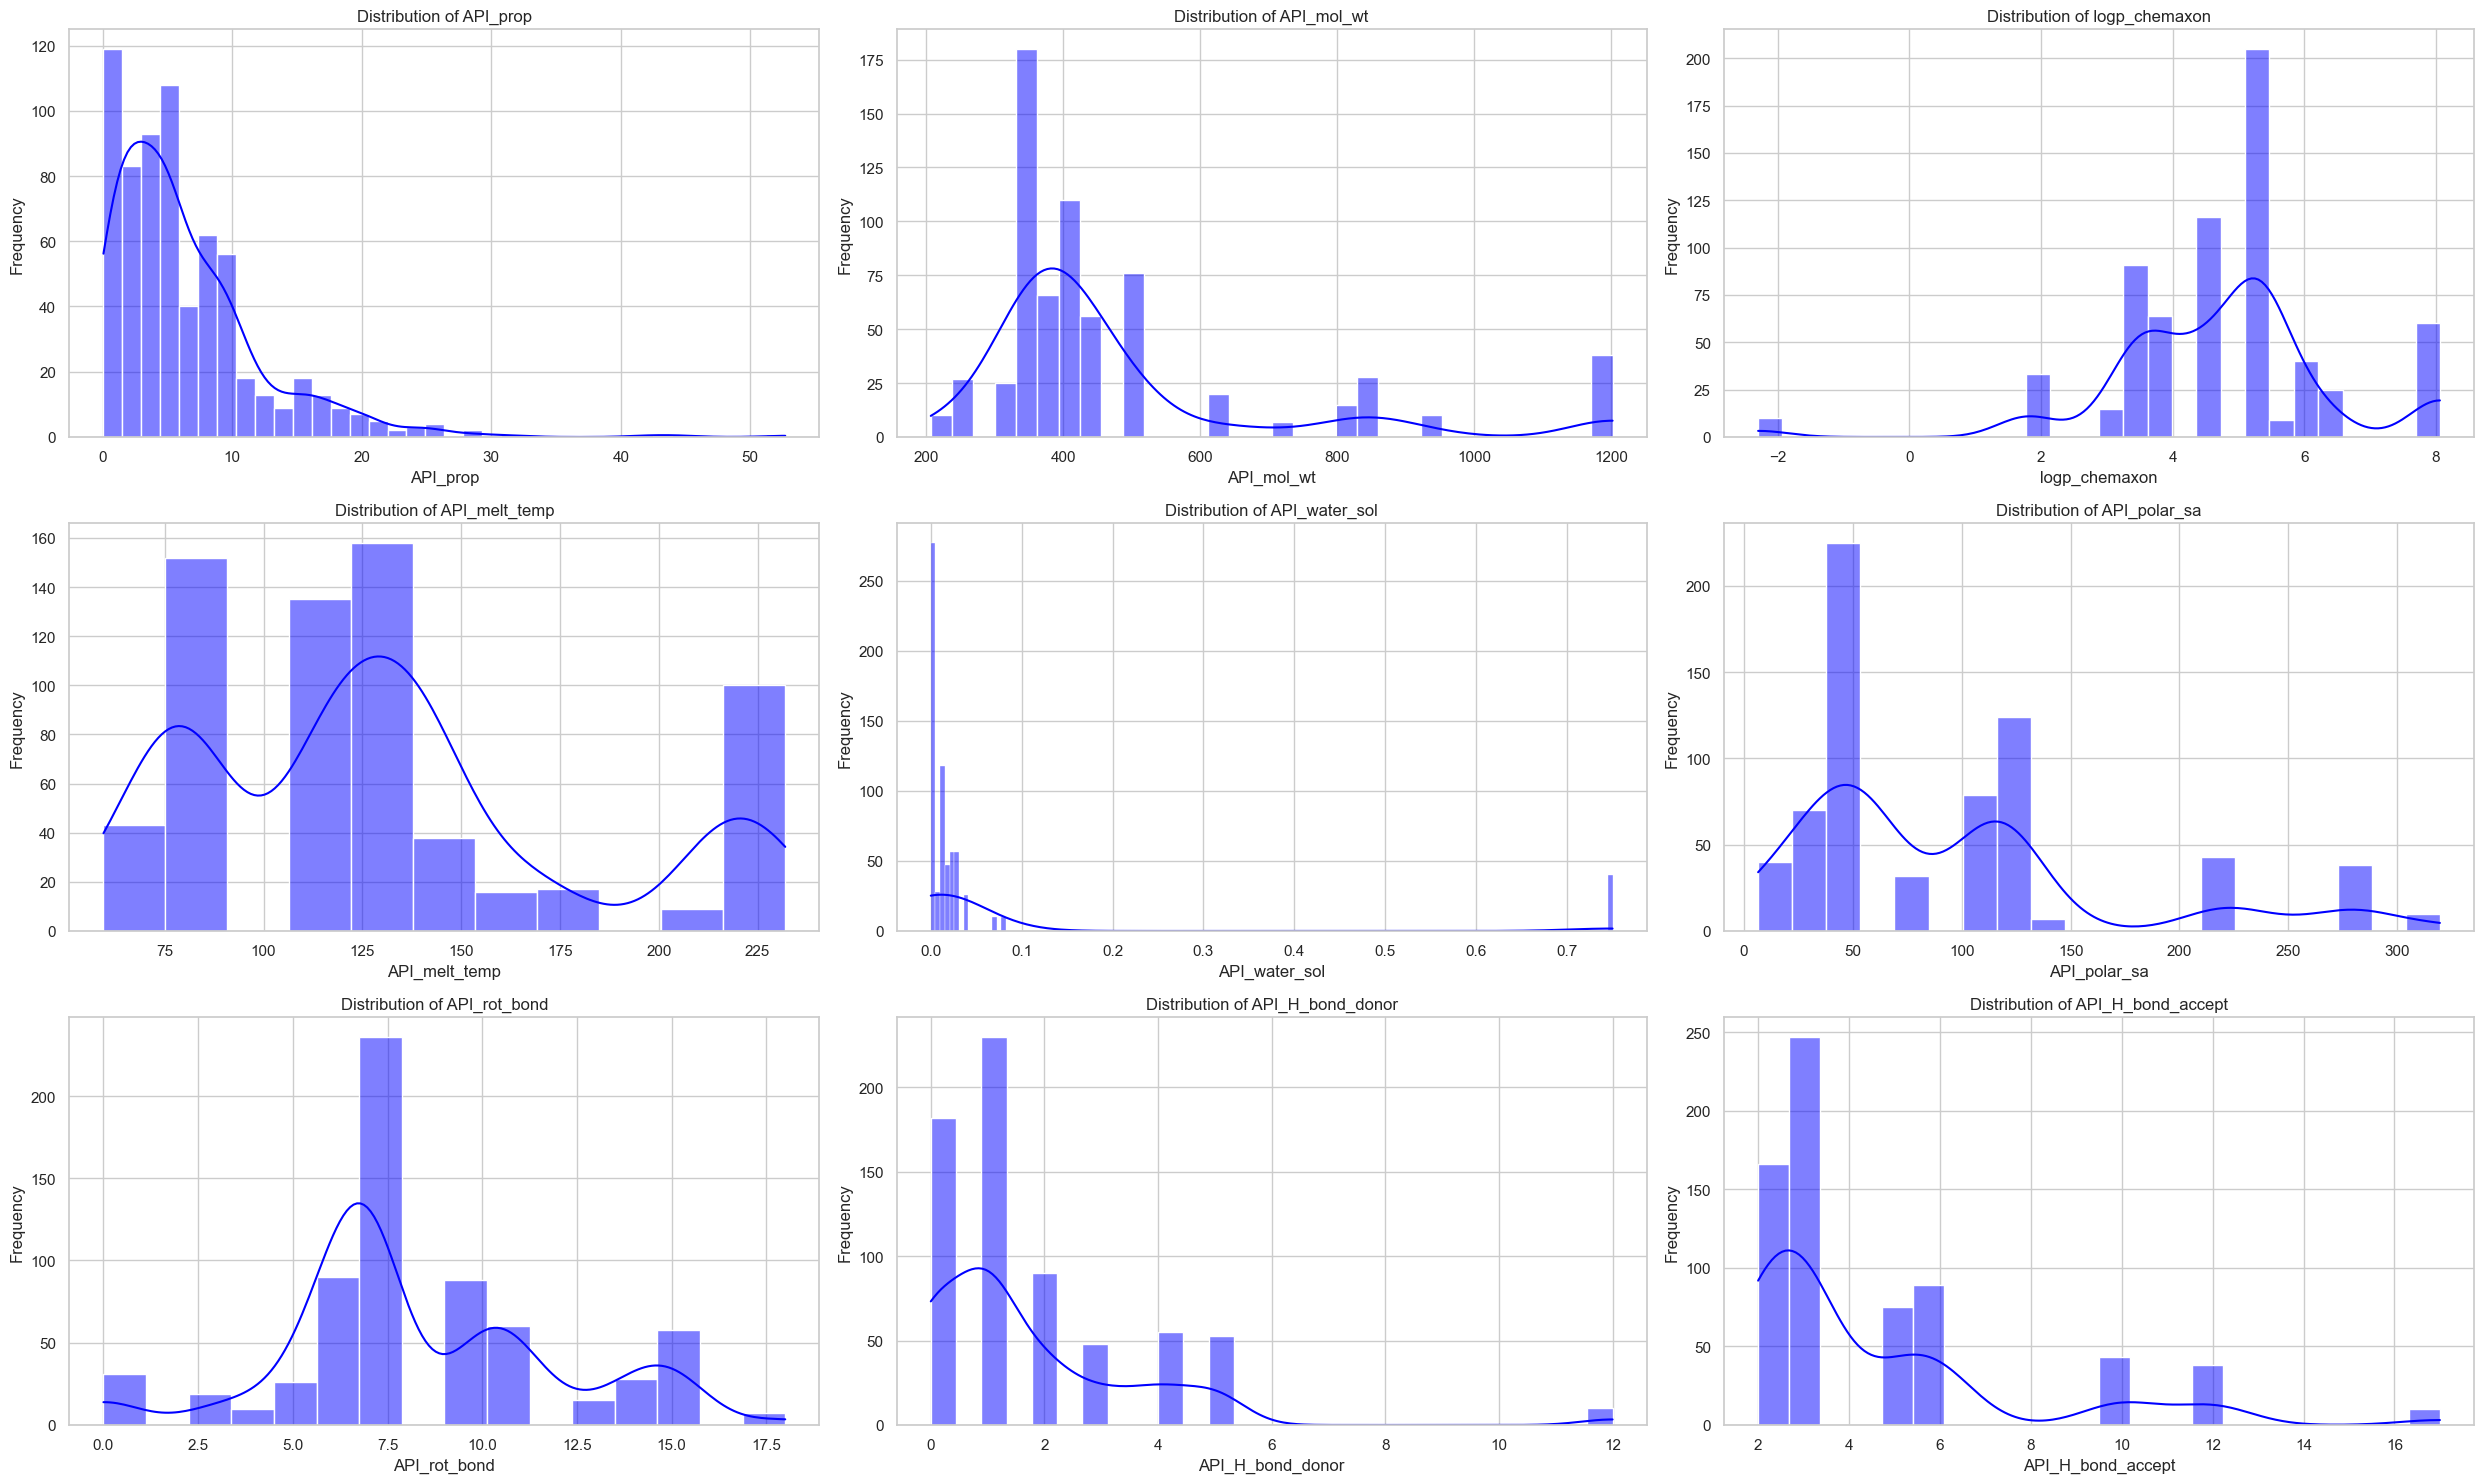

In [12]:
plot_utils.plot_histogram(features=FeatureCategory.DRUG.value, data=drug_characteristics)

- **API_rot_bond**
    - peak around 7.5
    - fewer occurrences as the number increases
- **API_H_bond_donor and API_H_bond_accept**
    - most records in this dataset likely have few hydrogen bond donors or acceptors
- **logp_chemaxon**
    - diverse
- **APL_water_sol**
    - right skewed (as expected), poorly soluble in water
- **APL_mol_wt**
    - distribution seems to be centered around two points, 400 and 600
- **APL_polar_sa**
    - peaks around 50, 100, and 250
- **APL_melt_temp**
    - melting temperatures around 80, 120 and 220 are more common
- **API_prop**
    - right skewed
    - smaller more common

- Based on the distribution of the drug features, we can see that there is few possible outliers.
- Solubility and hydrogen bonding capability of the drug should be relevant for the bioavailability or solubility of the SEDDS formulation.


In [13]:
(drug_characteristics.select('API_water_sol') > 0.6).sum()


API_water_sol
u32
40


In [14]:
data.select('API_water_sol').describe()

statistic,API_water_sol
str,f64
"""count""",668.0
"""null_count""",0.0
"""mean""",0.057113
"""std""",0.175672
"""min""",0.00011
"""25%""",0.00071
"""50%""",0.0122
"""75%""",0.0234
"""max""",0.75


In [15]:
(drug_characteristics
 .to_pandas()
 .corr()
 .style.background_gradient(cmap='coolwarm')
)

,API_prop,API_mol_wt,logp_chemaxon,API_melt_temp,API_water_sol,API_polar_sa,API_rot_bond,API_H_bond_donor,API_H_bond_accept
API_prop,1.000000,-0.136424,0.175957,-0.425138,-0.093596,-0.122260,0.086000,-0.109311,-0.137639
API_mol_wt,-0.136424,1.000000,-0.297109,0.386574,-0.108216,0.862084,0.706860,0.756904,0.854593
logp_chemaxon,0.175957,-0.297109,1.000000,-0.462547,0.116200,-0.645834,0.171072,-0.580385,-0.641734
API_melt_temp,-0.425138,0.386574,-0.462547,1.000000,-0.042647,0.465679,0.023153,0.402770,0.419037
API_water_sol,-0.093596,-0.108216,0.116200,-0.042647,1.000000,-0.261762,-0.176884,-0.177668,-0.159371
API_polar_sa,-0.122260,0.862084,-0.645834,0.465679,-0.261762,1.000000,0.501230,0.818830,0.942893
API_rot_bond,0.086000,0.706860,0.171072,0.023153,-0.176884,0.501230,1.000000,0.432225,0.503392
API_H_bond_donor,-0.109311,0.756904,-0.580385,0.402770,-0.177668,0.818830,0.432225,1.000000,0.873166
API_H_bond_accept,-0.137639,0.854593,-0.641734,0.419037,-0.159371,0.942893,0.503392,0.873166,1.000000


### Excipient characteristics

In [16]:
excipient_characteristics_features = FeatureCategory.OIL.value+FeatureCategory.SURFACTANT.value+FeatureCategory.COSOLVENT.value+FeatureCategory.OTHER_INGREDIENT.value

In [17]:
excipient_characteristics = data.select(excipient_characteristics_features) 

In [18]:
cat_excipient_characteristics = excipient_characteristics.select(cs.categorical()) 
num_excipient_characteristics = excipient_characteristics.select(cs.numeric()) 

In [19]:
cat_excipient_characteristics_features = list(cat_excipient_characteristics.columns)
num_excipient_characteristics_features = list(num_excipient_characteristics.columns)

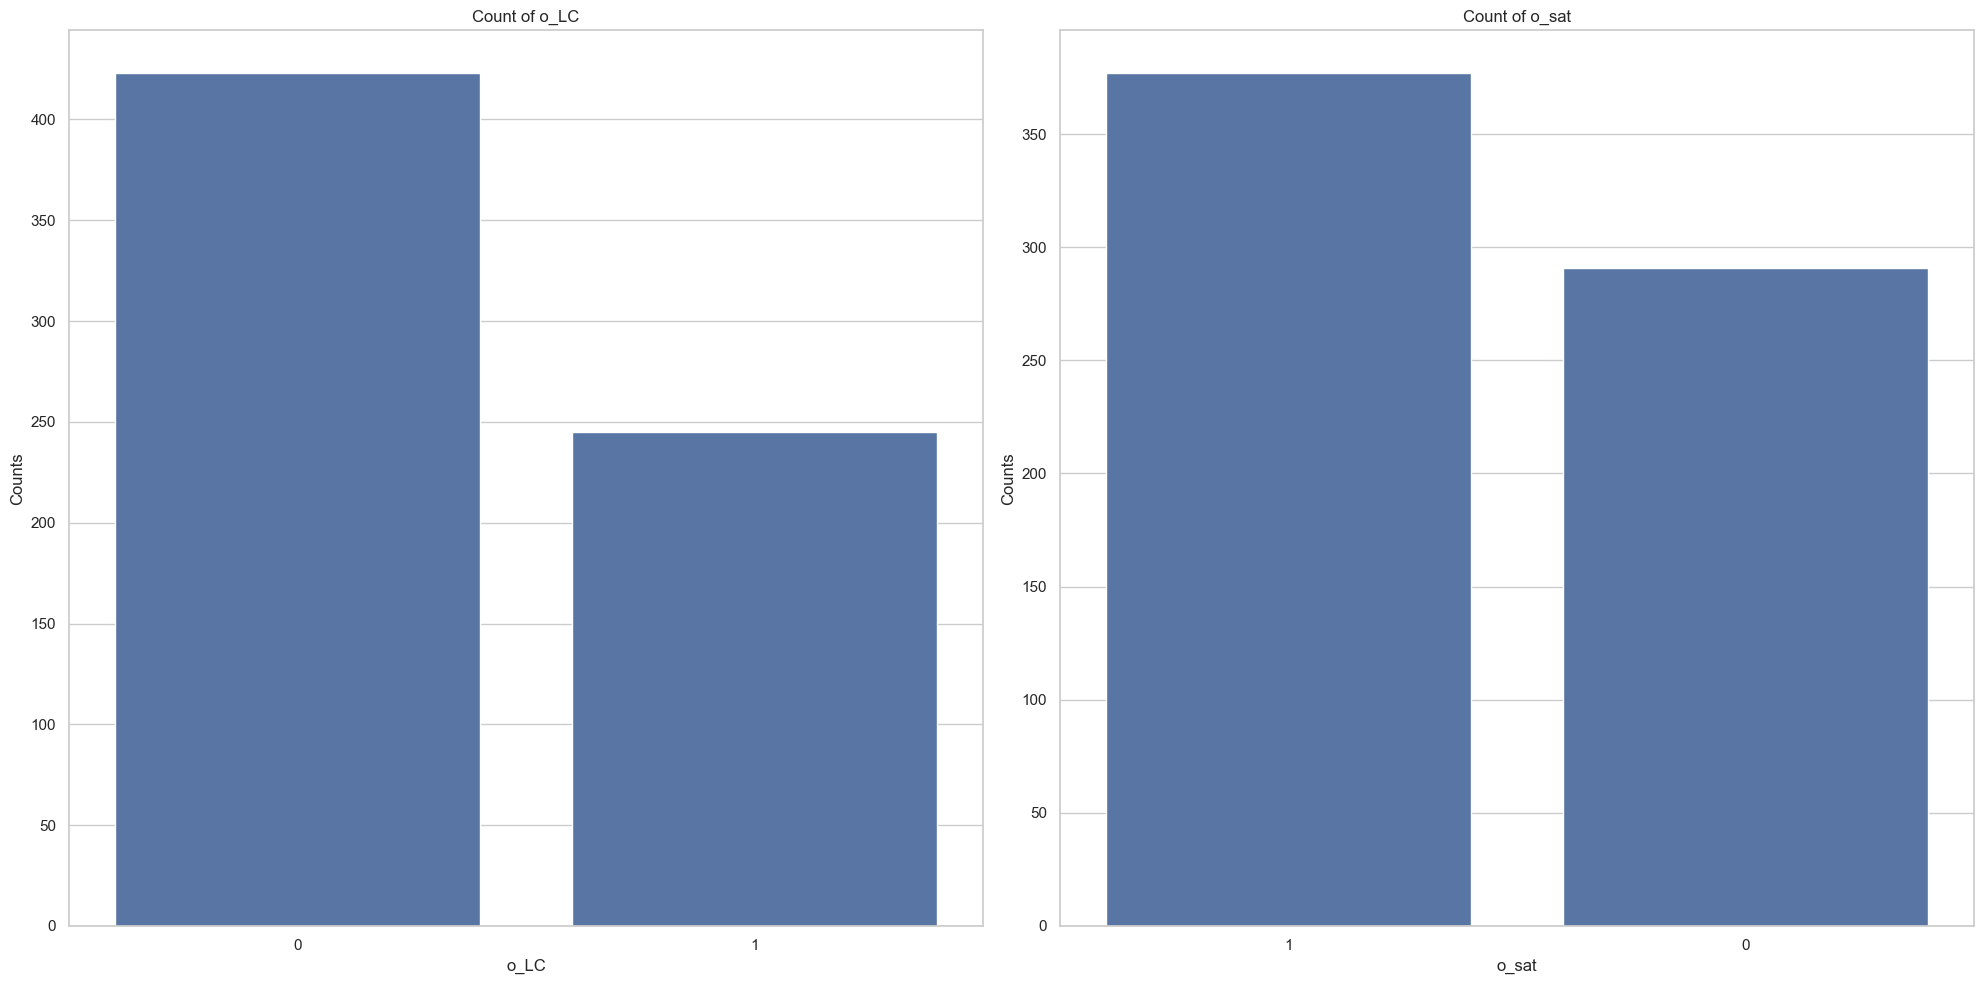

In [20]:
plot_utils.plot_bar_chart(features=cat_excipient_characteristics_features, data=cat_excipient_characteristics)

- Chain fatty acids more common.
- Saturated oils are more commonly used in the formulations.

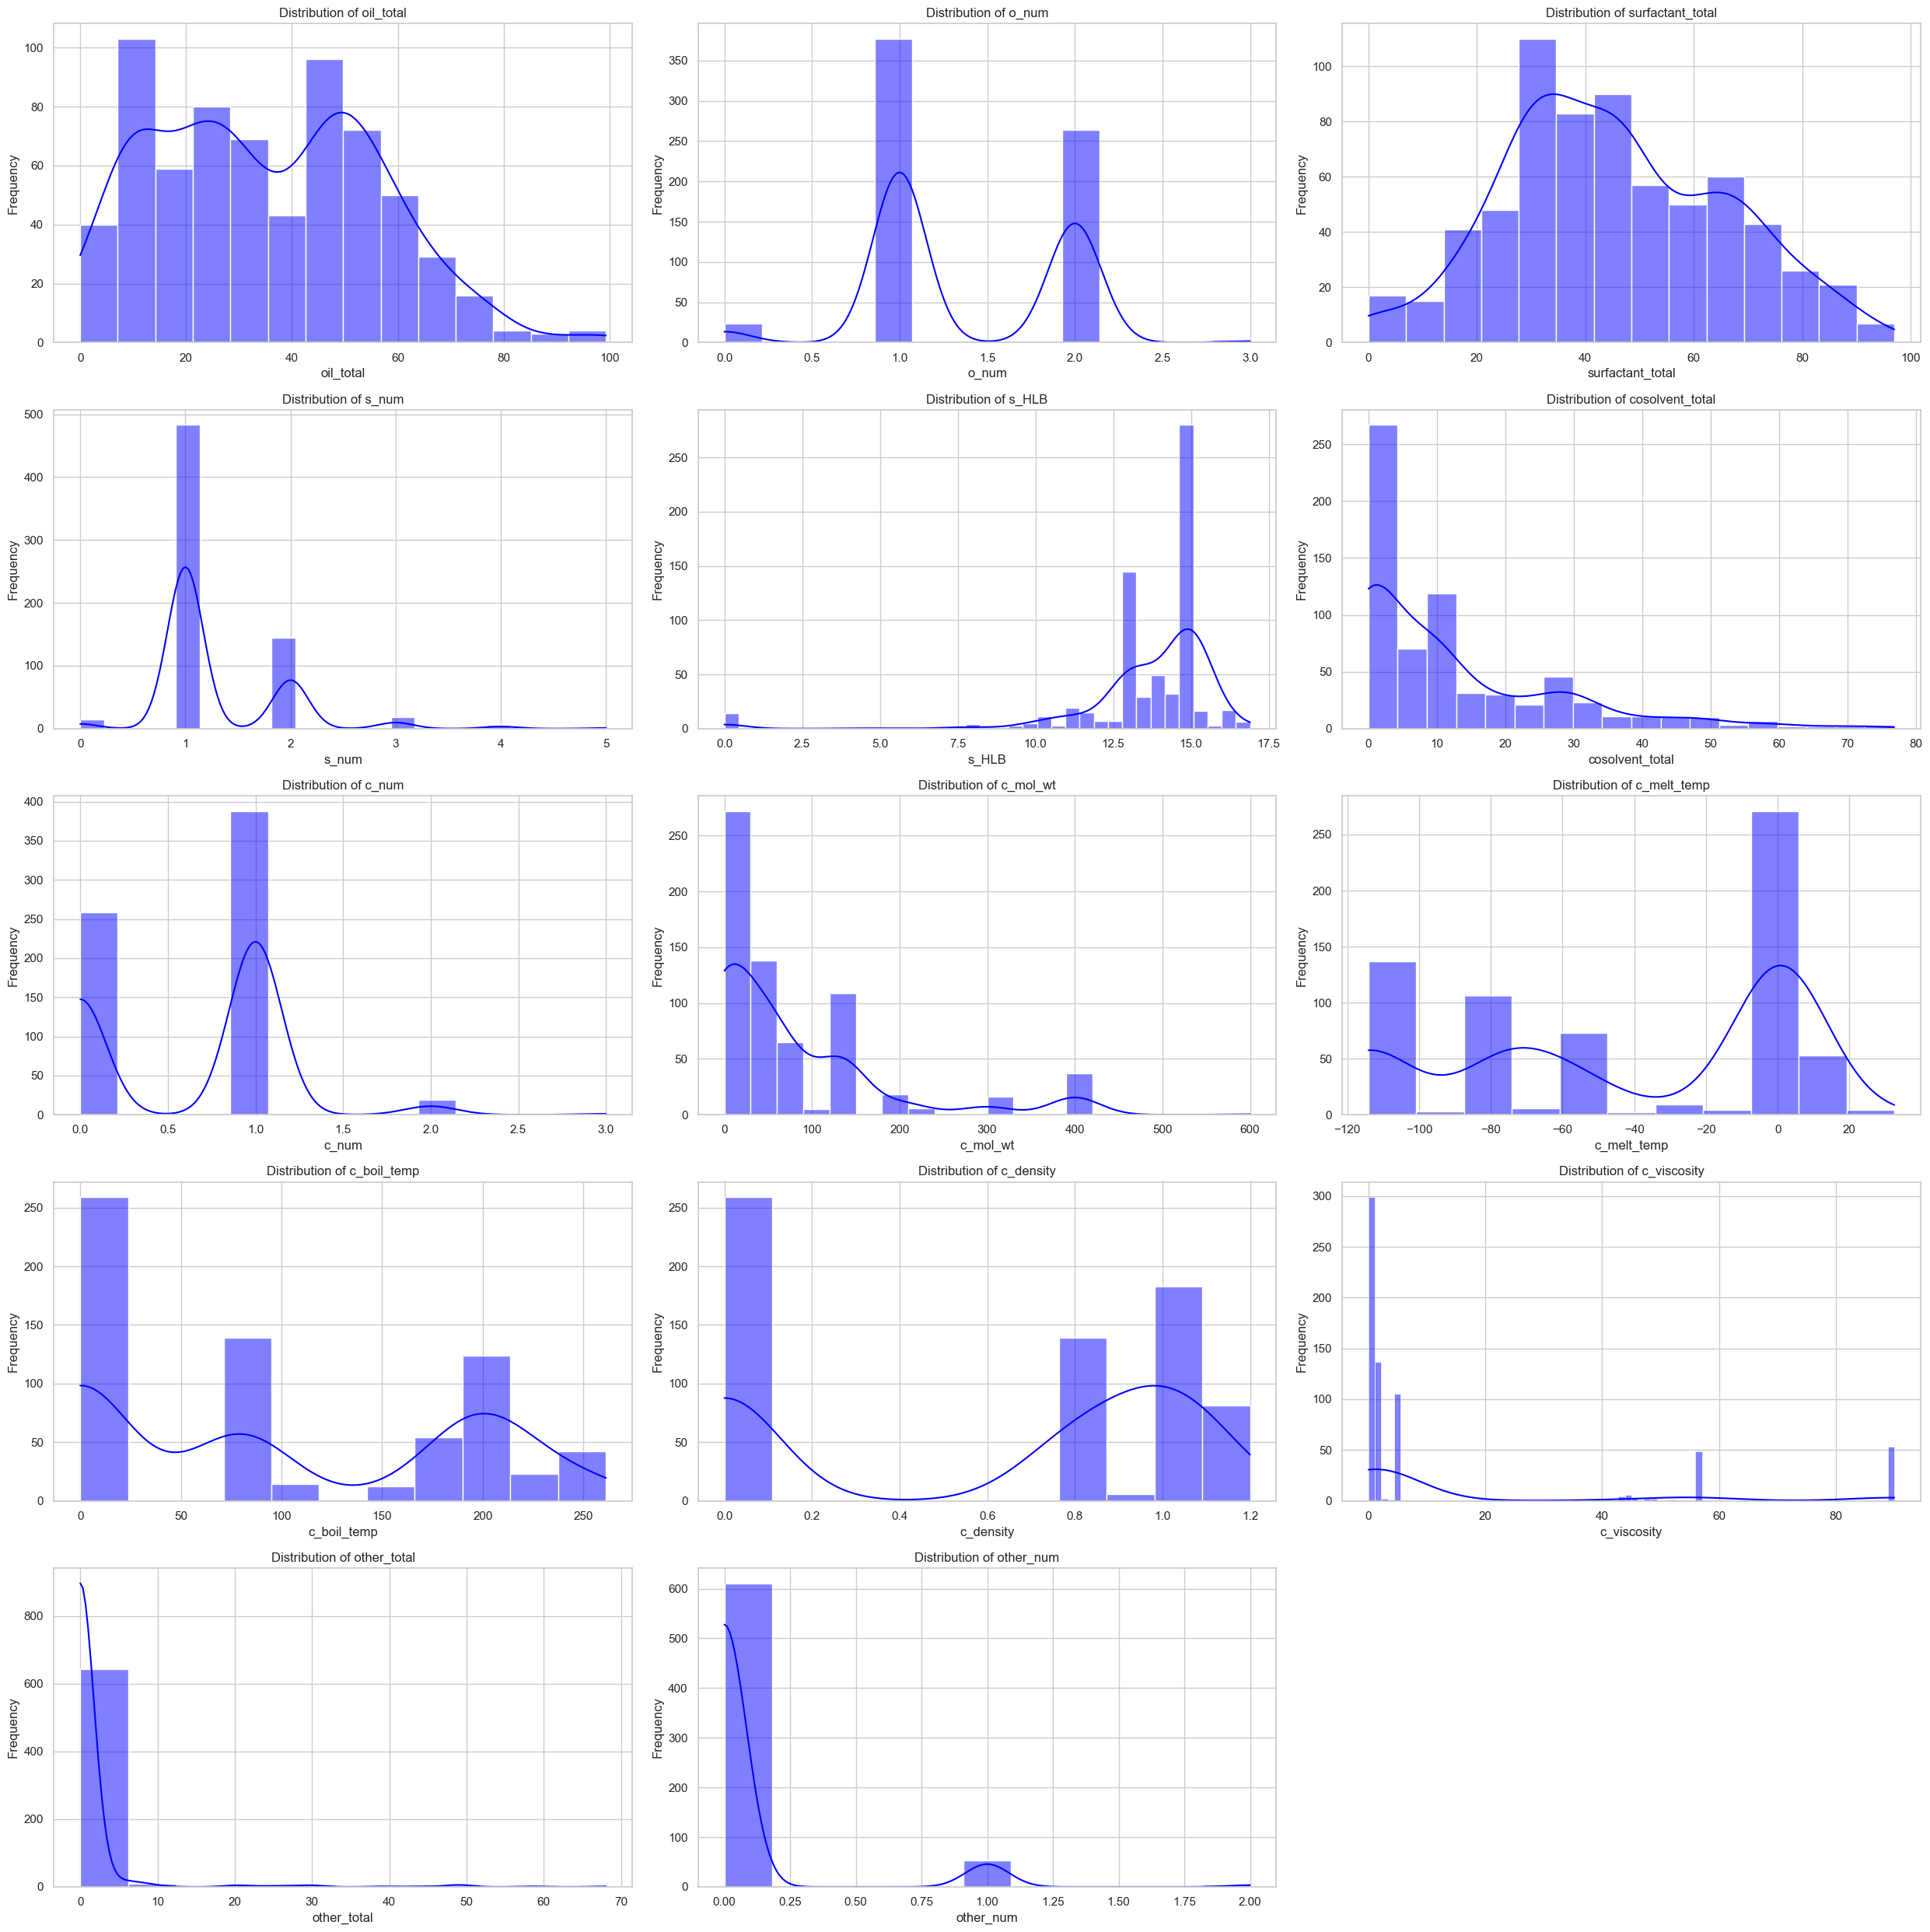

In [21]:
plot_utils.plot_histogram(features=num_excipient_characteristics_features, data=num_excipient_characteristics)

- 1 or combination of 1 or 2 mostly used.
- Mostly 1 surfactant used, as well as cosolvent.
- Less likely to use other ingredients together with oil, surfactant and cosolvent.
- Weight-averaged hydrophilic-lipophilic balance of surfactants in the formulation has a peak around 15.

In [22]:
(num_excipient_characteristics
 .to_pandas()
 .corr()
 .style.background_gradient(cmap='coolwarm')
)

,oil_total,o_num,surfactant_total,s_num,s_HLB,cosolvent_total,c_num,c_mol_wt,c_melt_temp,c_boil_temp,c_density,c_viscosity,other_total,other_num
oil_total,1.000000,0.591932,-0.682362,-0.363344,-0.281915,-0.466912,-0.157825,-0.313239,-0.075930,-0.277366,-0.212112,-0.104173,-0.008429,-0.070204
o_num,0.591932,1.000000,-0.347125,-0.261125,-0.024288,-0.334771,-0.141222,-0.293037,-0.156494,-0.332879,-0.214055,-0.273880,-0.110585,-0.099471
surfactant_total,-0.682362,-0.347125,1.000000,0.500408,0.268187,-0.208338,-0.237573,0.010701,0.351127,-0.134849,-0.209816,-0.000644,-0.247813,-0.186662
s_num,-0.363344,-0.261125,0.500408,1.000000,0.079023,-0.114937,-0.107855,-0.133538,0.174265,-0.206587,-0.184810,-0.120014,-0.189825,-0.028155
s_HLB,-0.281915,-0.024288,0.268187,0.079023,1.000000,0.220887,0.261747,0.157955,-0.195188,0.238958,0.268068,0.094261,-0.496742,-0.159745
cosolvent_total,-0.466912,-0.334771,-0.208338,-0.114937,0.220887,1.000000,0.617497,0.472024,-0.412936,0.638992,0.654350,0.190635,-0.071690,0.074786
c_num,-0.157825,-0.141222,-0.237573,-0.107855,0.261747,0.617497,1.000000,0.543316,-0.645123,0.785289,0.923642,0.383838,-0.084213,0.137172
c_mol_wt,-0.313239,-0.293037,0.010701,-0.133538,0.157955,0.472024,0.543316,1.000000,0.005530,0.821897,0.689547,0.752082,-0.078345,0.058188
c_melt_temp,-0.075930,-0.156494,0.351127,0.174265,-0.195188,-0.412936,-0.645123,0.005530,1.000000,-0.316933,-0.591234,0.178646,0.052415,-0.096999
c_boil_temp,-0.277366,-0.332879,-0.134849,-0.206587,0.238958,0.638992,0.785289,0.821897,-0.316933,1.000000,0.922412,0.634787,-0.082476,0.089762


### SEDDS Characteristics

In [23]:
sedds_characteristics = data.select(FeatureCategory.SEDDS.value)

In [24]:

num_sedds_characteristics = sedds_characteristics.select(cs.numeric())
cat_sedds_characteristics = sedds_characteristics.select(cs.categorical())

In [25]:
num_sedds_characteristics_features = list(num_sedds_characteristics.columns)
cat_sedds_characteristics_features = list(cat_sedds_characteristics.columns)

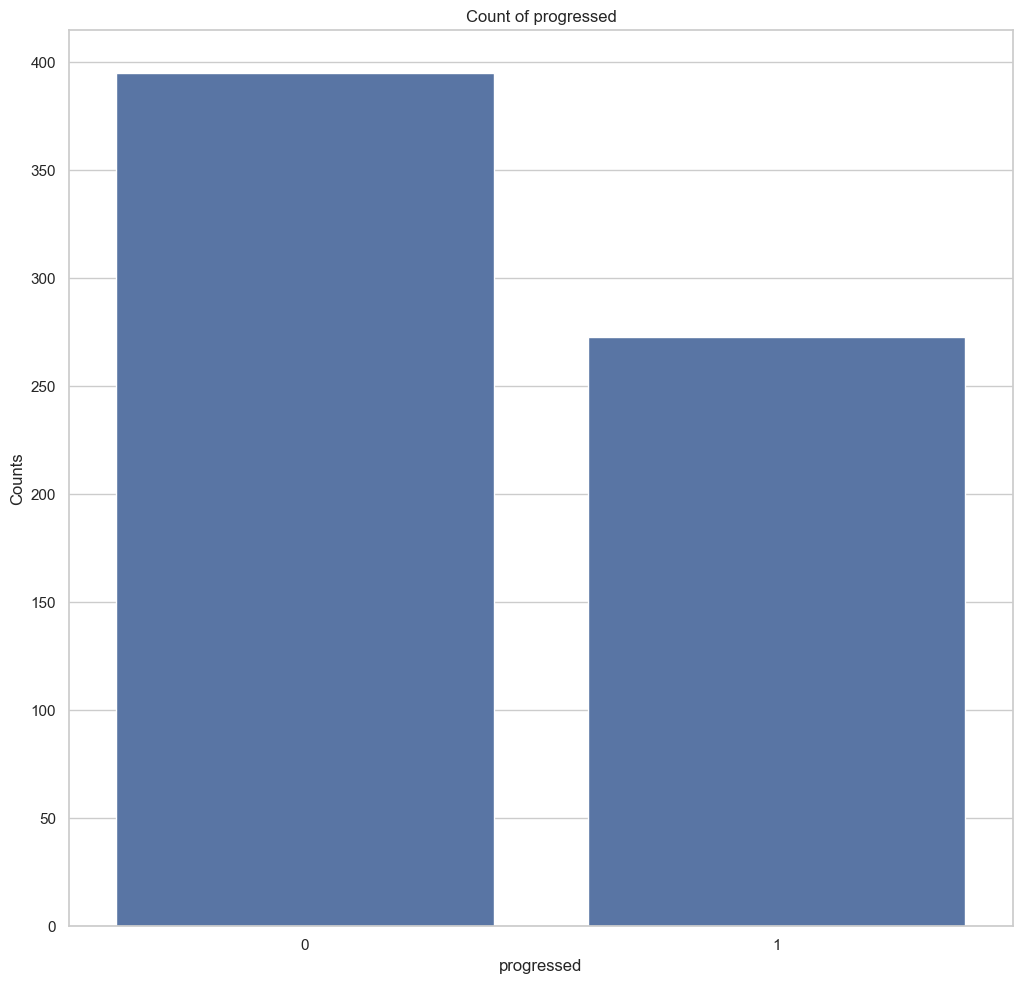

In [26]:
plot_utils.plot_bar_chart(features=cat_sedds_characteristics_features, data=cat_sedds_characteristics)

- Higher count of formulations that did not progress.


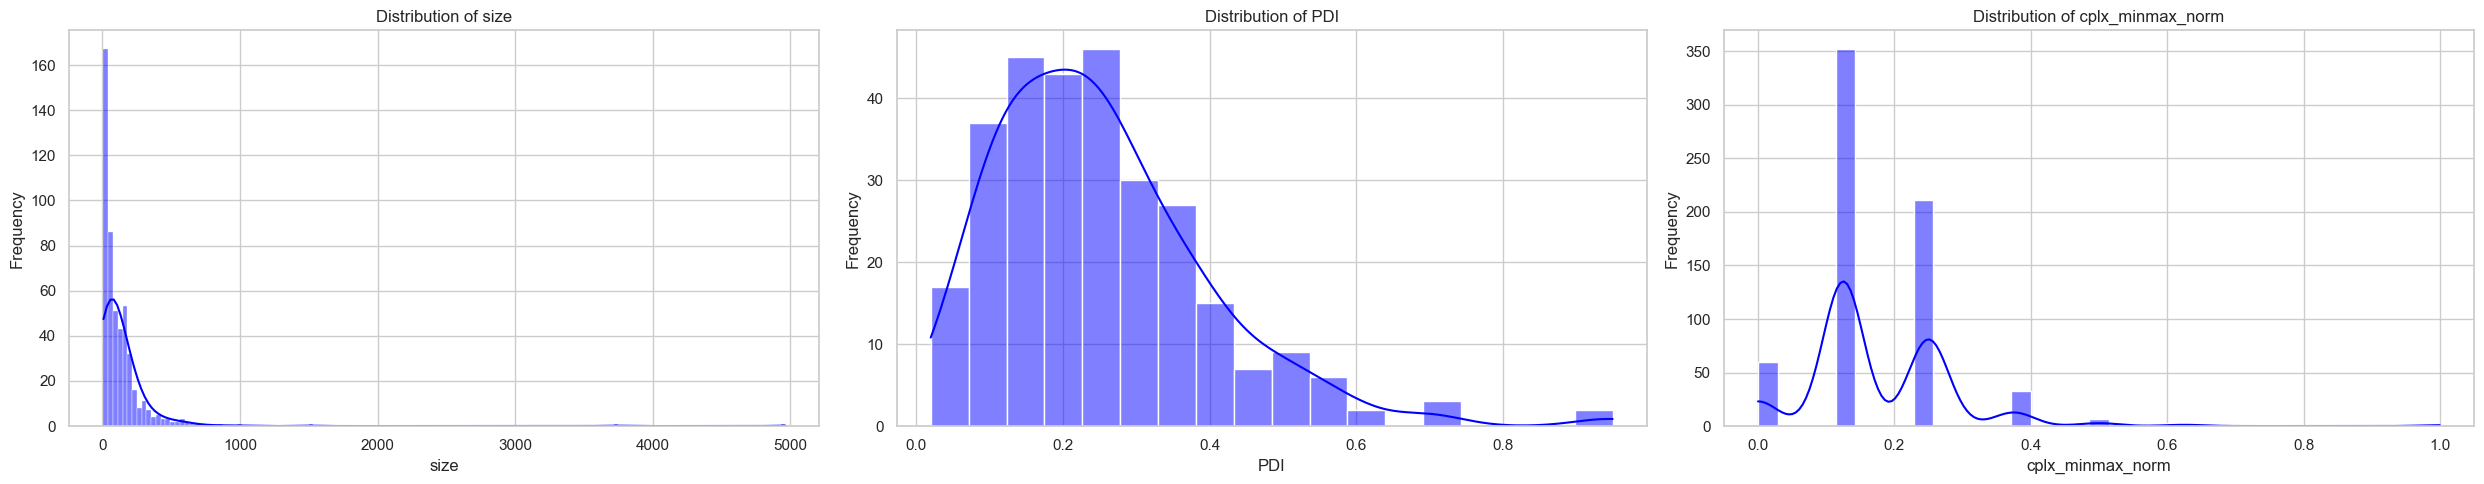

In [27]:
plot_utils.plot_histogram(features=num_sedds_characteristics_features, data=num_sedds_characteristics)

- Smaller size of the formulation more common.
- ? Relationship between size and progressed
- PDI centered around 0.2

In [28]:
(num_sedds_characteristics
 .to_pandas()
 .corr()
 .style.background_gradient(cmap='coolwarm')
)

,size,PDI,cplx_minmax_norm
size,1.000000,0.363794,-0.012344
PDI,0.363794,1.000000,-0.028336
cplx_minmax_norm,-0.012344,-0.028336,1.000000


### Relationships between categorical variables

In [29]:
categorical_data = data.select(cs.categorical())
categorical_features = categorical_data.columns
categorical_data

progressed,o_LC,o_sat
cat,cat,cat
"""0""","""0""","""1"""
"""0""","""0""","""1"""
"""0""","""0""","""1"""
"""0""","""0""","""1"""
"""1""","""0""","""1"""
…,…,…
"""0""","""0""","""1"""
"""0""","""0""","""1"""
"""1""","""0""","""1"""


In [30]:
chi_square_results = {}
chi_square_results = list(map(lambda i: list(map(lambda j: {
    (categorical_features[i], categorical_features[j]): {
        'chi2': chi2_contingency(pd.crosstab(categorical_data[categorical_features[i]], categorical_data[categorical_features[j]]))[0],
        'p-value': chi2_contingency(pd.crosstab(categorical_data[categorical_features[i]], categorical_data[categorical_features[j]]))[1]
    }
}, range(i + 1, len(categorical_features)))), range(len(categorical_features))))
chi_square_results = {k: v for sublist in chi_square_results for subsublist in sublist for k, v in subsublist.items()}

In [31]:
chi_square_results

{('progressed', 'o_LC'): {'chi2': 14.570786258270157,
  'p-value': 0.00013499120085359617},
 ('progressed', 'o_sat'): {'chi2': 19.156425562716837,
  'p-value': 1.2043140285475844e-05},
 ('o_LC', 'o_sat'): {'chi2': 490.429261894062,
  'p-value': 1.1492372696442255e-108}}

- small p-values, rejecting null hypothesis
- Results shows statistically significant association between the progression of the formulation and the character of the oil. (i.e. oil medium or long chain fatty acids.)
- Statistically significant relationship between the progression of the formulation and whether the oil is predominantly unsaturated or saturated.